In [1]:
import numpy as np
from typing import Callable
from matplotlib import pyplot as plt
from os import listdir
import optuna
from tqdm.notebook import tqdm

In [2]:
#чтение файл и запись в data

dir_name = 'messages'

def read_file(filename) -> tuple[set, int]:
    with open(filename) as f:
        content = set(map(int, f.readline().split()[1:]))
        f.readline()
        content.update(map(int, f.readline().split()))
        is_spam = int('spmsg' in filename)
        return content, is_spam

def read_part(dirname: str) -> tuple[np.ndarray, np.ndarray]:
    x, y = [], []
    for filename in listdir(dirname):
        content, is_spam = read_file(f"{dirname}/{filename}")
        x.append(content)
        y.append(is_spam)
    return np.array(x), np.array(y)

def read_data(dirname: str) -> np.ndarray:
    data = []
    for part_dir in listdir(dirname):
        data.append(read_part(f"{dirname}/{part_dir}"))
    return np.array(data)

def train_test_xy_split_data(data: np.ndarray, i: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train, test = np.concatenate([data[:i], data[i + 1:]]), data[i]
    return np.concatenate(train[:, 0]), np.concatenate(train[:, 1]), test[0], test[1]

data = read_data(dir_name)

In [3]:
#алгоритм наивного байесовского классификатора

class Bayes:
    def __init__(self, n: int = None, alpha: float = 0, l=None):
        if n is None and l is None:
            raise Exception

        if n is None:
            n = len(l)

        if l is None:
            l = np.ones(n)

        self.n = n
        self.alpha = alpha
        self.l = l
        self.p_y = None
        self.p_wy = None

    def fit(self, x_train: np.ndarray, y_train: np.ndarray):
        p_y = dict()
        p_wy = dict()
        all_words = set()

        for w in x_train:
            all_words.update(w)

        for y in range(self.n):
            p_y[y] = 0
            p_wy[y] = dict()
            for word in all_words:
                p_wy[y][word] = 0

        for y, words in zip(y_train, x_train):
            p_y[y] += 1
            for w in words:
                p_wy[y][w] += 1

        for y in p_wy.keys():
            for w in p_wy[y].keys():
                p_wy[y][w] = (p_wy[y][w] + self.alpha) / (p_y[y] + 2 * self.alpha)
            p_y[y] /= n

        self.p_y = p_y
        self.p_wy = p_wy
        return self

    def get_probabilities(self, x: set) -> np.ndarray:
        import math
        p_pred = []

        def safe_log(val: float) -> float:
            if val == 0:
                return -math.inf
            else:
                return math.log(val)

        for y in range(self.n):
            p = safe_log(self.l[y] * self.p_y[y])
            for w in self.p_wy[y]:
                if w in x:
                    p += safe_log(self.p_wy[y][w])
                else:
                    p += safe_log(1 - self.p_wy[y][w])
            p_pred.append(p)

        p_pred_max = max(p_pred)
        p_pred = list(map(lambda p: math.exp(p - p_pred_max), p_pred))
        sum_p_pred = sum(p_pred)
        p_pred = list(map(lambda p: p / sum_p_pred, p_pred))

        return np.array(p_pred)

    def predict1(self, x: set) -> int:
        return int(np.argmax(self.get_probabilities(x)))

    def predict(self, x: np.ndarray) -> np.ndarray:
        return np.vectorize(self.predict1)(x)

In [4]:
# проверим для n = 1..3
log = []
for n in tqdm(range(1, 4)):
    for alpha in tqdm(np.linspace(0, 0.1, 10)):
        x = np.concatenate(data[:, 0])
        model = Bayes(n, alpha).fit(x, np.random.randint(0, n, len(x)))
        probs = model.get_probabilities(x[0])
        log.append(f"n={n} alpha={alpha} probs={probs}")

log

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

['n=1 alpha=0.0 probs=[1.]',
 'n=1 alpha=0.011111111111111112 probs=[1.]',
 'n=1 alpha=0.022222222222222223 probs=[1.]',
 'n=1 alpha=0.03333333333333333 probs=[1.]',
 'n=1 alpha=0.044444444444444446 probs=[1.]',
 'n=1 alpha=0.05555555555555556 probs=[1.]',
 'n=1 alpha=0.06666666666666667 probs=[1.]',
 'n=1 alpha=0.07777777777777778 probs=[1.]',
 'n=1 alpha=0.08888888888888889 probs=[1.]',
 'n=1 alpha=0.1 probs=[1.]',
 'n=2 alpha=0.0 probs=[0.69730654 0.30269346]',
 'n=2 alpha=0.011111111111111112 probs=[1.00000000e+00 7.32281839e-22]',
 'n=2 alpha=0.022222222222222223 probs=[2.411337e-20 1.000000e+00]',
 'n=2 alpha=0.03333333333333333 probs=[9.99999992e-01 7.94863433e-09]',
 'n=2 alpha=0.044444444444444446 probs=[6.08037711e-25 1.00000000e+00]',
 'n=2 alpha=0.05555555555555556 probs=[0.36557223 0.63442777]',
 'n=2 alpha=0.06666666666666667 probs=[1.00000000e+00 6.83126596e-12]',
 'n=2 alpha=0.07777777777777778 probs=[0.07086456 0.92913544]',
 'n=2 alpha=0.08888888888888889 probs=[2.621

In [5]:
#считаем accuracy по формуле
def accuracy(y_pred: np.ndarray, y_test: np.ndarray) -> float:
    return np.count_nonzero(y_pred == y_test) / len(y_pred)

#делаем кросс валидацию
def cross_validate(
        model_supplier: Callable[[], Bayes],
        loss_f: Callable[[np.ndarray, np.ndarray], float] = accuracy,
        k: int = 10,
) -> float:
    acc = 0
    for i in range(k):
        x_train, y_train, x_test, y_test = train_test_xy_split_data(data, i)
        y_pred = model_supplier().fit(x_train, y_train).predict(x_test)
        acc += loss_f(y_pred, y_test)
    return acc / k

In [6]:
#подбор наилучших параметров

study = optuna.create_study(direction="maximize")

def objective(trial: optuna.Trial) -> float:
    alpha = trial.suggest_uniform("alpha", 0, 1)
    l1 = trial.suggest_uniform("l1", 0, 1)
    l2 = trial.suggest_uniform("l2", 0, 1)

    model_supplier = lambda: Bayes(alpha=alpha, l=[l1, l2])
    return cross_validate(model_supplier)

study.optimize(objective, n_trials=20, show_progress_bar=True)
best_params = study.best_params
best_params

[I 2022-10-26 09:57:46,116] A new study created in memory with name: no-name-234cbce7-064c-4eae-b98d-2edc7675daec
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/gq/n88br3s11t9c2zct8n333z0m0000gn/T/ipykernel_62656/3070974369.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0, 1)
/var/folders/gq/n88br3s11t9c2zct8n333z0m0000gn/T/ipykernel_62656/3070974369.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1 = trial.suggest_uniform("l1", 0, 1)
/var/folders/gq/n88br3s11t9c2zct8n333z0m0000gn/T/ipykernel_62656/3070974369.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2 = trial.suggest_

[I 2022-10-26 09:58:09,475] Trial 0 finished with value: 0.9339449541284406 and parameters: {'alpha': 0.7708277988477782, 'l1': 0.050603290821661706, 'l2': 0.7822461527554774}. Best is trial 0 with value: 0.9339449541284406.
[I 2022-10-26 09:58:30,741] Trial 1 finished with value: 0.9275229357798166 and parameters: {'alpha': 0.8366497467598242, 'l1': 0.6474526839601135, 'l2': 0.9154121845012464}. Best is trial 0 with value: 0.9339449541284406.
[I 2022-10-26 09:58:51,818] Trial 2 finished with value: 0.9449541284403669 and parameters: {'alpha': 0.3436582797144295, 'l1': 0.6469515179127668, 'l2': 0.5375733031955008}. Best is trial 2 with value: 0.9449541284403669.
[I 2022-10-26 09:59:12,872] Trial 3 finished with value: 0.9504587155963302 and parameters: {'alpha': 0.058263741778461164, 'l1': 0.9831457844581698, 'l2': 0.06265978942956563}. Best is trial 3 with value: 0.9504587155963302.
[I 2022-10-26 09:59:34,147] Trial 4 finished with value: 0.9366972477064222 and parameters: {'alpha': 0

/var/folders/gq/n88br3s11t9c2zct8n333z0m0000gn/T/ipykernel_62656/3070974369.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1 = trial.suggest_uniform("l1", 0, 1)
/var/folders/gq/n88br3s11t9c2zct8n333z0m0000gn/T/ipykernel_62656/3070974369.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2 = trial.suggest_uniform("l2", 0, 1)


[I 2022-10-26 10:01:46,116] Trial 10 finished with value: 0.9559633027522935 and parameters: {'alpha': 0.05122783711925908, 'l1': 0.4467025489639602, 'l2': 0.24803581475289582}. Best is trial 10 with value: 0.9559633027522935.


/var/folders/gq/n88br3s11t9c2zct8n333z0m0000gn/T/ipykernel_62656/3070974369.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_uniform("alpha", 0, 1)


[I 2022-10-26 10:02:10,760] Trial 11 finished with value: 0.956880733944954 and parameters: {'alpha': 0.023740146772676773, 'l1': 0.41576090709994584, 'l2': 0.22083418420711956}. Best is trial 11 with value: 0.956880733944954.
[I 2022-10-26 10:02:34,763] Trial 12 finished with value: 0.956880733944954 and parameters: {'alpha': 0.005458803262911878, 'l1': 0.4343843954385562, 'l2': 0.2623487697917912}. Best is trial 11 with value: 0.956880733944954.
[I 2022-10-26 10:02:57,723] Trial 13 finished with value: 0.9477064220183486 and parameters: {'alpha': 0.21523738701109507, 'l1': 0.4592781318898531, 'l2': 0.2813125068738674}. Best is trial 11 with value: 0.956880733944954.
[I 2022-10-26 10:03:22,904] Trial 14 finished with value: 0.9486238532110092 and parameters: {'alpha': 0.2145605939349043, 'l1': 0.2883637017398637, 'l2': 0.3681888548001983}. Best is trial 11 with value: 0.956880733944954.
[I 2022-10-26 10:03:45,149] Trial 15 finished with value: 0.9587155963302753 and parameters: {'alph

{'alpha': 0.004079033689129383,
 'l1': 0.3957710199710527,
 'l2': 0.5907149335814645}

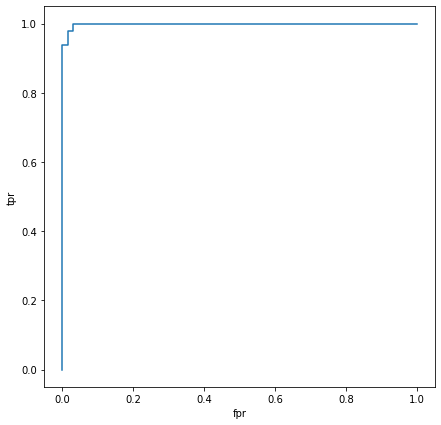

In [7]:
#ROC-кривая для обученной модели

from sklearn.metrics import roc_curve

model = Bayes(alpha=best_params["alpha"], l=[best_params["l1"], best_params["l2"]])
x_train, y_train, x_test, y_test = train_test_xy_split_data(data, 0)
trained_model = model.fit(x_train, y_train)
y_pred = np.array(list(map(trained_model.get_probabilities, x_test)))[:, 1]

fpr, tpr, _ = roc_curve(y_test.astype('int64'), y_pred)

plt.figure(figsize=(7, 7))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot(fpr, tpr)

### Подберем l_legit при фиксированном l_spam

In [8]:
#Подберем штраф ошибки классификации λlegit такой, чтобы ни одно реальное (legit) сообщение не было 
#классифицировано как спам. Штраф λspam при этом зафиксирован.

def all_true_are_positive(y_pred: np.ndarray, y_test: np.ndarray) -> float:
    tp, t = 0, 0
    for y1, y2 in zip(y_pred, y_test):
        if y2 == 1:
            t += 1
        if y1 == y2 == 1:
            tp += 1
    return tp / t if t > 0 else 1

loss1 = []
loss2 = []
l_legit = best_params["l1"]

while True:
    model_supplier = lambda: Bayes(alpha=best_params["alpha"], l=[best_params["l1"], l_legit])
    a1 = cross_validate(model_supplier, all_true_are_positive)
    a2 = cross_validate(model_supplier)
    loss1.append(a1)
    loss2.append(a2)
    print(a1)
    if a1 == 1:
        break
    l_legit *= 10

print(l_legit)

0.9208333333333334
0.93125
0.94375
0.9520833333333332
0.9520833333333332
0.9645833333333332
0.9729166666666667
0.9729166666666667
0.9791666666666666
0.98125
0.9854166666666666
0.9854166666666666
0.9875
0.9875
0.9895833333333334
0.99375
0.99375
0.99375
0.99375
0.99375
0.99375
0.9958333333333332
0.9979166666666666
0.9979166666666666
0.9979166666666666
0.9979166666666666
0.9979166666666666
1.0
3.957710199710526e+26


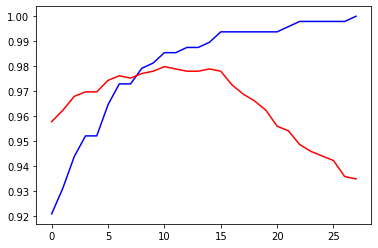

In [9]:
# l = 0.2 .. 0.2 * 10**25 , step = *10
#график зависимости точности от параметра λlegit, где λlegit изменяется от значения по умолчанию (λlegit = λspam)
plt.plot(loss1, color='blue')
plt.plot(loss2, color='red')